In [95]:
# high lr in the beginning and gradually decrease
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import gym.spaces
from matplotlib import pyplot as plt
%matplotlib inline

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.001                   # learning rate
EPSILON = 0.95               # greedy policy
GAMMA = 0.99                 # reward discount
TARGET_REPLACE_ITER = 10000   # target update frequency
MEMORY_CAPACITY = 500000
env = gym.make('LunarLander-v2')
#env = env.unwrapped
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


In [96]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 100)
        self.fc1.weight.data.fill_(0)   # initialization
        self.out = nn.Linear(100, N_ACTIONS)
        self.out.weight.data.fill_(0)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [97]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.random() > EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            #print actions_value
            action = torch.max(actions_value, 1)[1].data.numpy()            
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def test_choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.target_net.forward(x)
        #print actions_value
        action = torch.max(actions_value, 1)[1].data.numpy()            
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = F.smooth_l1_loss(q_eval, q_target)
        #loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [98]:
dqn = DQN()
reward_list = []
running_r = 0
running_r_list = []

print('\nCollecting experience...')
for i_episode in range(5000):
    if i_episode%100 == 0: print('Ep: ', i_episode, '| Running_r: ', round(running_r, 2))
    s = env.reset()
    ep_r = 0
    step = 0
    if i_episode > 50 and EPSILON > 0.05: EPSILON = EPSILON - 0.001 
    if LR > 0.00001: LR = LR - 0.00001
    while True:
        #env.render()
        a = dqn.choose_action(s)        

        # take action
        s_, r, done, info = env.step(a)
        step = step + 1

        ep_r += r
    
        #if r == -100: r = -30

        dqn.store_transition(s, a, r, s_)
        
        #if dqn.memory_counter > 0:
        if dqn.memory_counter > MEMORY_CAPACITY/100:
            dqn.learn()
            if done:
                running_r = 0.99*running_r + 0.01*ep_r
                running_r_list.append(running_r)
                #print('Ep: ', i_episode,'| R: ', r, '| Ep_r: ', round(ep_r, 2), '| Running_r: ', round(running_r, 2))
        if done:
            reward_list.append(ep_r)
            break
            
        if step > 1000:
            ep_r = ep_r - 100
            running_r = 0.99*running_r + 0.01*ep_r
            running_r_list.append(running_r)
            #print('Ep: ', i_episode,'Step: ', step,'| Ep_r: ', round(ep_r, 2), '| Running_r: ', round(running_r, 2))
            reward_list.append(ep_r)
            break
            
        s = s_
print('\nComplete')


('Ep: ', 0, '| Running_r: ', 0.0)
('Ep: ', 100, '| Running_r: ', -86.59)
('Ep: ', 200, '| Running_r: ', -162.58)
('Ep: ', 300, '| Running_r: ', -166.99)
('Ep: ', 400, '| Running_r: ', -158.14)
('Ep: ', 500, '| Running_r: ', -126.96)
('Ep: ', 600, '| Running_r: ', -101.75)
('Ep: ', 700, '| Running_r: ', -78.59)
('Ep: ', 800, '| Running_r: ', -97.98)
('Ep: ', 900, '| Running_r: ', -115.2)
('Ep: ', 1000, '| Running_r: ', -111.37)
('Ep: ', 1100, '| Running_r: ', -80.87)
('Ep: ', 1200, '| Running_r: ', 7.28)
('Ep: ', 1300, '| Running_r: ', 89.69)
('Ep: ', 1400, '| Running_r: ', 107.92)
('Ep: ', 1500, '| Running_r: ', 117.69)
('Ep: ', 1600, '| Running_r: ', 90.34)
('Ep: ', 1700, '| Running_r: ', 120.26)
('Ep: ', 1800, '| Running_r: ', 142.55)
('Ep: ', 1900, '| Running_r: ', 145.52)
('Ep: ', 2000, '| Running_r: ', 151.74)
('Ep: ', 2100, '| Running_r: ', 161.59)
('Ep: ', 2200, '| Running_r: ', 177.0)
('Ep: ', 2300, '| Running_r: ', 171.26)
('Ep: ', 2400, '| Running_r: ', 184.08)
('Ep: ', 2500

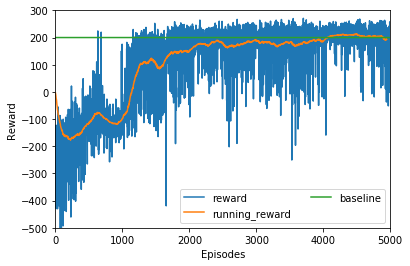

In [140]:
#env.close()
baseline = []
for i in range (1,5000): baseline.append(200)
plt.plot(reward_list)
plt.plot(running_r_list)
plt.plot(baseline)
plt.axis([0, 5000, -500, 300])
plt.xlabel("Episodes")
plt.ylabel("Reward")
label = ["reward", "running_reward", "baseline"]
plt.legend(label, loc = 0, ncol = 2)

In [171]:
# test
env = gym.make('LunarLander-v2')
avg = 0
while True:    
    test_reward_list = []
    for i_episode in range(100):
        s = env.reset()
        ep_r = 0
        step = 0
        #EPSILON = -1    
        while True:
            #env.render()
            s = torch.unsqueeze(torch.FloatTensor(s), 0)
            # input only one sample
            actions_value = dqn.target_net.forward(s)
            #print actions_value
            action = torch.max(actions_value, 1)[1].data.numpy()            
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)

            a = action

            # take action
            s_, r, done, info = env.step(a)
            step = step + 1
            ep_r += r

            #if done:
                #print('Ep: ', i_episode,'| R: ', r, '| Ep_r: ', round(ep_r, 2))

            if r == 100 or r == -100 or step > 3000:
                test_reward_list.append(ep_r)
                #print('Ep: ', i_episode, '| Ep_r: ', round(ep_r, 2))
                break            
            s = s_
            step = step + 1
    #print('\nComplete')
    avg = sum(test_reward_list)/len(test_reward_list)
    print avg
    if avg > 200:
        break

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
183.52107939788468
181.66223285913327
184.94757409744855
184.02681664726714
184.84769216795104
179.37952382974288
188.5537655141319
184.98906752559571
177.35235541410034
185.1987711455482
185.8414724988782
182.886357542967
180.34288311875406
186.05541543915072
185.20700283940684
185.37504973619198
176.69102443703218
183.43361885111995
182.21101383405679
178.99538811270358
191.48595557578938
181.51660343624866
177.0761371081101
177.18823533242852
177.73318090439145
178.4447206833214
181.1432877012654
186.00919791900327
178.7582504404364
188.05626770348042
184.8166362448745
172.40638515279937
180.78370325791784
183.9122099716678
184.0602283284835
173.2567734126625
184.8540920142111
180.88327581704016
177.34913596542955
178.99230525927294
179.35320889380597
176.84831814308654
184.46970740454398
188.91595500045435
187.47240120057342
180.85445855220985
189.050509623774
183.1483076270106
178.575

KeyboardInterrupt: 

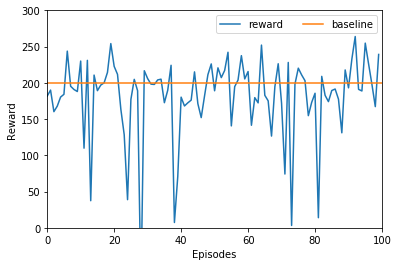

In [161]:
#env.close()
baseline = []
for i in range (1,5000): baseline.append(200)
plt.plot(test_reward_list)
#plt.plot(running_r_list)
plt.plot(baseline)
plt.axis([0, 100, 0, 300])
plt.xlabel("Episodes")
plt.ylabel("Reward")
label = ["reward", "baseline"]
plt.legend(label, loc = 0, ncol = 2)